In [1]:
# Add the root directory to the sys.path
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

base_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(base_dir, '../'))
sys.path.append(root_dir)
print(f"Root directory added to sys.path: {root_dir}")

Root directory added to sys.path: c:\Users\Admin\Documents\GitHub\FederatedLearning


In [2]:
# Import the Data class from the data module
from data.data import Data

d = Data(
    batch_size=128,
    partitioner= 1,
    partition_size = 50000,
    val_size=0.2,
    include_test_set=True,
)

trainloader, valloader, testloader = d.load_datasets(partition_id=0)


c:\Users\Admin\Documents\GitHub\FederatedLearning\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Admin\Documents\GitHub\FederatedLearning\env\Lib\site-packages\flwr_datasets\utils.py:109: UserWarning: The currently tested dataset are ['mnist', 'ylecun/mnist', 'cifar10', 'uoft-cs/cifar10', 'fashion_mnist', 'zalando-datasets/fashion_mnist', 'sasha/dog-food', 'zh-plus/tiny-imagenet', 'scikit-learn/adult-census-income', 'cifar100', 'uoft-cs/cifar100', 'svhn', 'ufldl-stanford/svhn', 'sentiment140', 'stanfordnlp/sentiment140', 'speech_commands', 'LIUM/tedlium', 'flwrlabs/femnist', 'flwrlabs/ucf101', 'flwrlabs/ambient-acoustic-context', 'jlh/uci-mushrooms', 'Mike0307/MNIST-M', 'flwrlabs/usps', 'scikit-learn/iris', 'flwrlabs/pacs', 'flwrlabs/cinic10', 'flwrlabs/caltech101', 'flwrlabs/office-home', 'flwrlabs/

In [3]:
print(f"Number of samples in the training dataset: {len(trainloader.dataset)}")
print(f"Number of samples in the validation dataset: {len(valloader.dataset)}")
print(f"Number of samples in the test dataset: {len(testloader.dataset)}")


Number of samples in the training dataset: 40000
Number of samples in the validation dataset: 10000
Number of samples in the test dataset: 10000


In [83]:
# Load pre-trained ResNet18 model
model = models.wide_resnet50_2(pretrained=True)

# Modify the final fully connected layer to output 10 classes (for CIFAR-10)
model.fc = nn.Linear(model.fc.in_features, 10)


# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer for better convergence
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 2
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for batch in trainloader:
        # Extract images and labels from the batch dictionary
        inputs, targets = batch["img"].to(device), batch["label"].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Print stats after each epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = (correct / total) * 100
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_correct = 0
    val_total = 0
    with torch.no_grad():  # No gradients needed for validation
        for batch in valloader:
            # Extract images and labels from the batch dictionary
            inputs, targets = batch["img"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    val_accuracy = (val_correct / val_total) * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1/2], Loss: 1.1174, Accuracy: 62.52%
Validation Accuracy: 68.26%
Epoch [2/2], Loss: 0.6790, Accuracy: 77.65%
Validation Accuracy: 76.58%


In [84]:
# After training, evaluate on the test set
model.eval()  # Set model to evaluation mode for testing
correct = 0
total = 0

with torch.no_grad():  # No gradients needed for evaluation
    for batch in testloader:
        # Extract images and labels from the batch dictionary
        inputs, targets = batch["img"].to(device), batch["label"].to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get predictions and compare with actual labels
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

test_accuracy = (correct / total) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 76.88%


In [57]:

# # Directory containing the JSONL files
# base_dir = os.path.abspath(os.path.join(os.getcwd(), "../results/Data_size_test/test_1/8/reconstruction"))

# Function to load tensors and labels from the JSONL files
def load_jsonl_files(base_dir):
    tensor_data = []
    labels_data = []
    
    # List all .jsonl files in the directory
    jsonl_files = [file for file in os.listdir(base_dir) if file.endswith(".jsonl")]

    # Combine predicted_images and true_labels from all JSONL files
    for file_name in jsonl_files:
        file_path = os.path.join(base_dir, file_name)
        
        # Read each .jsonl file and extract predicted_images and true_labels
        with open(file_path, 'r') as f:
            for line in f:
                json_data = json.loads(line.strip())  # Read line and parse JSON
                
                # Check if 'reconstruction' and 'predicted_images' exist
                if "reconstruction" in json_data and "predicted_images" in json_data["reconstruction"]:
                    predicted_images = json_data["reconstruction"]["predicted_images"]  # Adjust the key if it's different
                    
                    # Loop over the batch and append each image tensor individually
                    for img in predicted_images:  # Each img is of shape [3, 32, 32]
                        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert each image to tensor
                        tensor_data.append(img_tensor)
                    
                # Extract the true labels (assuming 'true_labels' exists)
                if "reconstruction" in json_data and "true_labels" in json_data["reconstruction"]:
                    true_labels = json_data["reconstruction"]["true_labels"]  # Adjust the key if it's different       
                    # Loop over the labels (one per image) and append each label tensor individually
                    for label in true_labels:  # Each label corresponds to an image
                        true_labels_tensor = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
                        labels_data.append(true_labels_tensor)

    # Now, ensure that tensor_data and labels_data have the expected 80 total items
    return tensor_data, labels_data

# # Load the tensors and labels
# tensor_data, labels_data = load_jsonl_files(base_dir)



In [43]:
# Verify the shape and contents
print(f"Number of image tensors: {len(tensor_data)}")  # Should be 80 (10 files, 8 tensors per file)
print(f"Number of labels: {len(labels_data)}")  # Should also be 80

# Check the shape of the first image tensor
print(f"Shape of the first image tensor: {tensor_data[0].shape}")  # Expected: [8, 3, 32, 32] for each batch

# Check the shape of the first label tensor
print(f"Shape of the first label tensor: {labels_data[0].shape}")  # Expected: [8] (one label per image)


Number of image tensors: 80
Number of labels: 80
Shape of the first image tensor: torch.Size([3, 32, 32])
Shape of the first label tensor: torch.Size([])


In [58]:

# Create a custom Dataset for PyTorch DataLoader
class TensorDataset(Dataset):
    def __init__(self, tensor_data, labels_data):
        self.data = tensor_data
        self.labels = labels_data
        
        # Define the normalization transform
        self.normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # CIFAR-10 mean and std

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        
        # Normalize the image tensor
        img = self.normalize(img)  # Apply normalization to the image
        
        return img, label

# # Assuming `tensor_data` and `labels_data` are already loaded correctly
# tensor_dataset = TensorDataset(tensor_data, labels_data)

# # Create a DataLoader to iterate over the tensors
# tensor_dataloader = DataLoader(tensor_dataset, batch_size=32, shuffle=False)



In [36]:
# Print the shapes and types of tensors in the dataloader
for batch_idx, (inputs, labels) in enumerate(tensor_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f" - Inputs shape: {inputs.shape}")  # Shape of images (e.g., [batch_size, 3, 32, 32])
    print(f" - Labels shape: {labels.shape}")  # Shape of labels (e.g., [batch_size]) 
    print("-" * 50)

Batch 1:
 - Inputs shape: torch.Size([32, 3, 32, 32])
 - Labels shape: torch.Size([32])
--------------------------------------------------
Batch 2:
 - Inputs shape: torch.Size([32, 3, 32, 32])
 - Labels shape: torch.Size([32])
--------------------------------------------------
Batch 3:
 - Inputs shape: torch.Size([32, 3, 32, 32])
 - Labels shape: torch.Size([32])
--------------------------------------------------
Batch 4:
 - Inputs shape: torch.Size([32, 3, 32, 32])
 - Labels shape: torch.Size([32])
--------------------------------------------------
Batch 5:
 - Inputs shape: torch.Size([32, 3, 32, 32])
 - Labels shape: torch.Size([32])
--------------------------------------------------
Batch 6:
 - Inputs shape: torch.Size([32, 3, 32, 32])
 - Labels shape: torch.Size([32])
--------------------------------------------------
Batch 7:
 - Inputs shape: torch.Size([32, 3, 32, 32])
 - Labels shape: torch.Size([32])
--------------------------------------------------
Batch 8:
 - Inputs shape: t

In [ ]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0
conf = 0
# Assuming you have a `device` variable set for the model (either CPU or CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
with torch.no_grad():  # No gradients needed for evaluation
    for inputs, labels in tensor_dataloader:

        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        # Get predictions and compare with actual labels
        batch_conf, predicted = torch.max(probabilities, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if predicted == labels:    
            conf += batch_conf.sum().item()

conf = conf / total
print(f"Confidence: {conf:.2f}")
test_accuracy = (correct / total) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")




Confidence: 0.77
Test Accuracy: 67.50%


In [85]:
import os
import torch
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

test_ids = ["test_1", "test_2", "test_3"]
data_sizes = [8, 16, 32, 64, 96, 128, 160]

all_accuracies = []
all_confidences = []

for test_id in test_ids:
    accuracies = []
    confidences = []

    for size in data_sizes:
        # Build path
        base_dir = os.path.abspath(os.path.join(os.getcwd(), f"../results/Data_size_test/{test_id}/{size}/reconstruction"))
        
        # Load data
        try:
            tensor_data, labels_data = load_jsonl_files(base_dir)
        except Exception as e:
            print(f"Failed to load data for {test_id} size {size}: {e}")
            accuracies.append(0)
            confidences.append(0)
            continue

        # Create DataLoader
        dataset = TensorDataset(tensor_data, labels_data)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

        # Evaluate
        correct = 0
        total = 0
        confidence_sum = 0.0

        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                probabilities = torch.softmax(outputs, dim=1)
                batch_conf, predicted = torch.max(probabilities, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                confidence_sum += batch_conf.sum().item()

        # Metrics
        avg_confidence = confidence_sum / total if total > 0 else 0
        accuracy = (correct / total) * 100 if total > 0 else 0
        accuracies.append(accuracy)
        confidences.append(avg_confidence)

        print(f"{test_id} size {size}: Accuracy = {accuracy:.2f}%, Confidence = {avg_confidence:.2f}")

    all_accuracies.append(accuracies)
    all_confidences.append(confidences)




test_1 size 8: Accuracy = 62.50%, Confidence = 0.76
test_1 size 16: Accuracy = 60.62%, Confidence = 0.75
test_1 size 32: Accuracy = 46.56%, Confidence = 0.71
test_1 size 64: Accuracy = 36.72%, Confidence = 0.67
test_1 size 96: Accuracy = 34.58%, Confidence = 0.67
test_1 size 128: Accuracy = 34.61%, Confidence = 0.67
test_1 size 160: Accuracy = 35.44%, Confidence = 0.68
test_2 size 8: Accuracy = 35.00%, Confidence = 0.64
test_2 size 16: Accuracy = 31.87%, Confidence = 0.60
test_2 size 32: Accuracy = 29.38%, Confidence = 0.57
test_2 size 64: Accuracy = 30.47%, Confidence = 0.58
test_2 size 96: Accuracy = 29.27%, Confidence = 0.57
test_2 size 128: Accuracy = 30.94%, Confidence = 0.58
test_2 size 160: Accuracy = 33.69%, Confidence = 0.57
test_3 size 8: Accuracy = 55.00%, Confidence = 0.73
test_3 size 16: Accuracy = 54.37%, Confidence = 0.75
test_3 size 32: Accuracy = 48.12%, Confidence = 0.73
test_3 size 64: Accuracy = 39.53%, Confidence = 0.68
test_3 size 96: Accuracy = 36.67%, Confidence

In [94]:
import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": False,  # Use LaTeX rendering for text
    "font.family": "serif",
    "font.size": 15,  # Adjust based on LaTeX document class
    "axes.labelsize": 17,
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "legend.fontsize": 15,
})


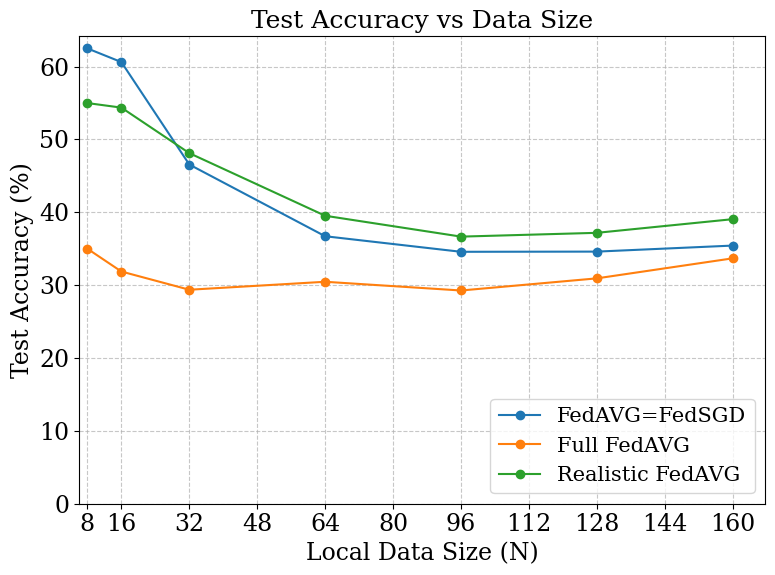

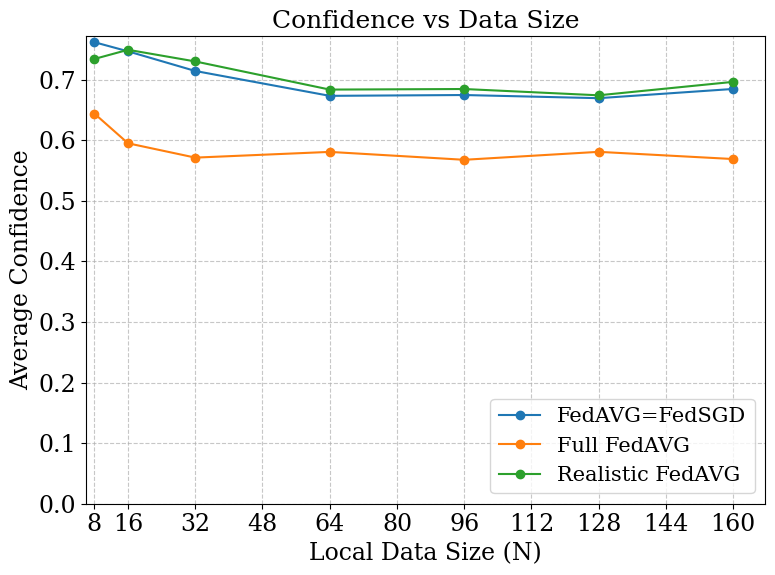

In [95]:
import matplotlib.pyplot as plt

# Labels for each line (FedAVG variants)
labels = ["FedAVG=FedSGD", "Full FedAVG", "Realistic FedAVG"]

# Define data sizes used in x-axis
data_sizes = [8, 16, 32, 64, 96, 128, 160]

plt.figure(figsize=(8, 6))# Slightly wider than square


for acc_values, label in zip(all_accuracies, labels):
    plt.plot(data_sizes, acc_values, marker='o', label=label)

plt.ylim(bottom=0)  # You can set e.g., bottom=50 if you want
plt.xlim(left=6)
plt.xticks([8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160])
plt.xlabel("Local Data Size (N)", loc="center")
plt.ylabel("Test Accuracy (%)", loc="center")
plt.title("Test Accuracy vs Data Size", loc="center")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)

# Final layout adjustments and export
plt.tight_layout()
plt.savefig("accuracy_plot.pdf", format="pdf")
plt.show()

plt.figure(figsize=(8, 6))
for conf_values, label in zip(all_confidences, labels):
    plt.plot(data_sizes, conf_values, marker='o', label=label)

plt.ylim(bottom=0)  # Adjust as needed
plt.xlim(left=6)
plt.xticks([8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160])
plt.xlabel("Local Data Size (N)", loc="center")
plt.ylabel("Average Confidence", loc="center")
plt.title("Confidence vs Data Size", loc="center")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)

# Final layout adjustments and export
plt.tight_layout()
plt.savefig("confidence_plot.pdf", format="pdf")
plt.show()

